<a href="https://colab.research.google.com/github/adem-maatallah/IT_Job_salary_prediction/blob/main/car_price_optuna_XGBR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [ ]:
zip_file_path = '/content/archive.zip'

# Create a list to store DataFrames for each CSV file
dfs = []

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Iterate through the files in the ZIP archive
    for file_name in zip_file.namelist():
        # Check if the file is a CSV file
        with zip_file.open(file_name) as csv_file:
            df = pd.read_csv(csv_file)
            # Append the DataFrame to the list
            dfs.append(df)


In [ ]:
dfs

[      model  year  price transmission  mileage fuelType  tax   mpg  engineSize
 0        A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4
 1        A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0
 2        A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4
 3        A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0
 4        A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0
 ...     ...   ...    ...          ...      ...      ...  ...   ...         ...
 10663    A3  2020  16999       Manual     4018   Petrol  145  49.6         1.0
 10664    A3  2020  16999       Manual     1978   Petrol  150  49.6         1.0
 10665    A3  2020  17199       Manual      609   Petrol  150  49.6         1.0
 10666    Q3  2017  19499    Automatic     8646   Petrol  150  47.9         1.4
 10667    Q3  2016  15999       Manual    11855   Petrol  150  47.9         1.4
 
 [10668 rows x 9 columns],
           

In [ ]:

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Now, combined_df contains all the data from the individual DataFrames


In [ ]:
combined_df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
70393,IQ,2011,5500,Automatic,30000,Petrol,20.0,58.9,1.0,NaN
70394,Urban Cruiser,2011,4985,Manual,36154,Petrol,125.0,50.4,1.3,NaN
70395,Urban Cruiser,2012,4995,Manual,46000,Diesel,125.0,57.6,1.4,NaN
70396,Urban Cruiser,2011,3995,Manual,60700,Petrol,125.0,50.4,1.3,NaN


In [ ]:
combined_df.loc[(combined_df['tax'].isna()) & (combined_df['tax(£)'].isna())]['model']

Series([], Name: model, dtype: object)

There are no cars with missing road tax

In [ ]:
combined_df['tax(£)'].isna().sum() + combined_df['tax'].isna().sum() == 70398

True

This means that the missing values in 'tax' and 'tax(£)' compliment each other so we will merge these two columns

In [ ]:
combined_df['tax']=combined_df['tax'].fillna(combined_df['tax(£)'])

In [ ]:
(combined_df[combined_df['tax(£)'].notna()]['tax'] == combined_df[combined_df['tax(£)'].notna()]['tax(£)']).all()

True

Missing values in tax are filled with complementary values of tax(£).Now we can drop the tax(£) column

In [ ]:
df=combined_df.drop(columns=['tax(£)'])

#Exploratory Data Analysis

##Missing values

In [ ]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
ZipFileName     0
dtype: int64

There are no missing values

##Descriptive statistics

In [ ]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,70398.000000,70398.000000,70398.000000,70398.000000,70398.000000,70398.000000
mean,2017.076550,18037.205361,23181.649095,120.287011,56.174424,1.724401
std,2.141514,10597.516999,21342.702158,64.523369,17.421733,0.605706
min,1970.000000,495.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,10700.000000,7374.000000,125.000000,47.900000,1.200000
50%,2017.000000,15750.000000,17410.000000,145.000000,56.500000,1.600000
75%,2019.000000,22450.000000,32466.750000,145.000000,64.200000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [ ]:
df.describe(exclude='number')

,model,transmission,fuelType,ZipFileName
count,70398,70398,70398,70398
unique,146,4,5,7
top,Fiesta,Manual,Petrol,ford.csv
freq,6557,35048,35570,17965


In [ ]:
df['ZipFileName']=df['ZipFileName'].str.replace('.csv', '')
df.rename(columns={'ZipFileName': 'brand'}, inplace=True)

<ipython-input-14-4ca225d31d04>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['ZipFileName']=df['ZipFileName'].str.replace('.csv', '')


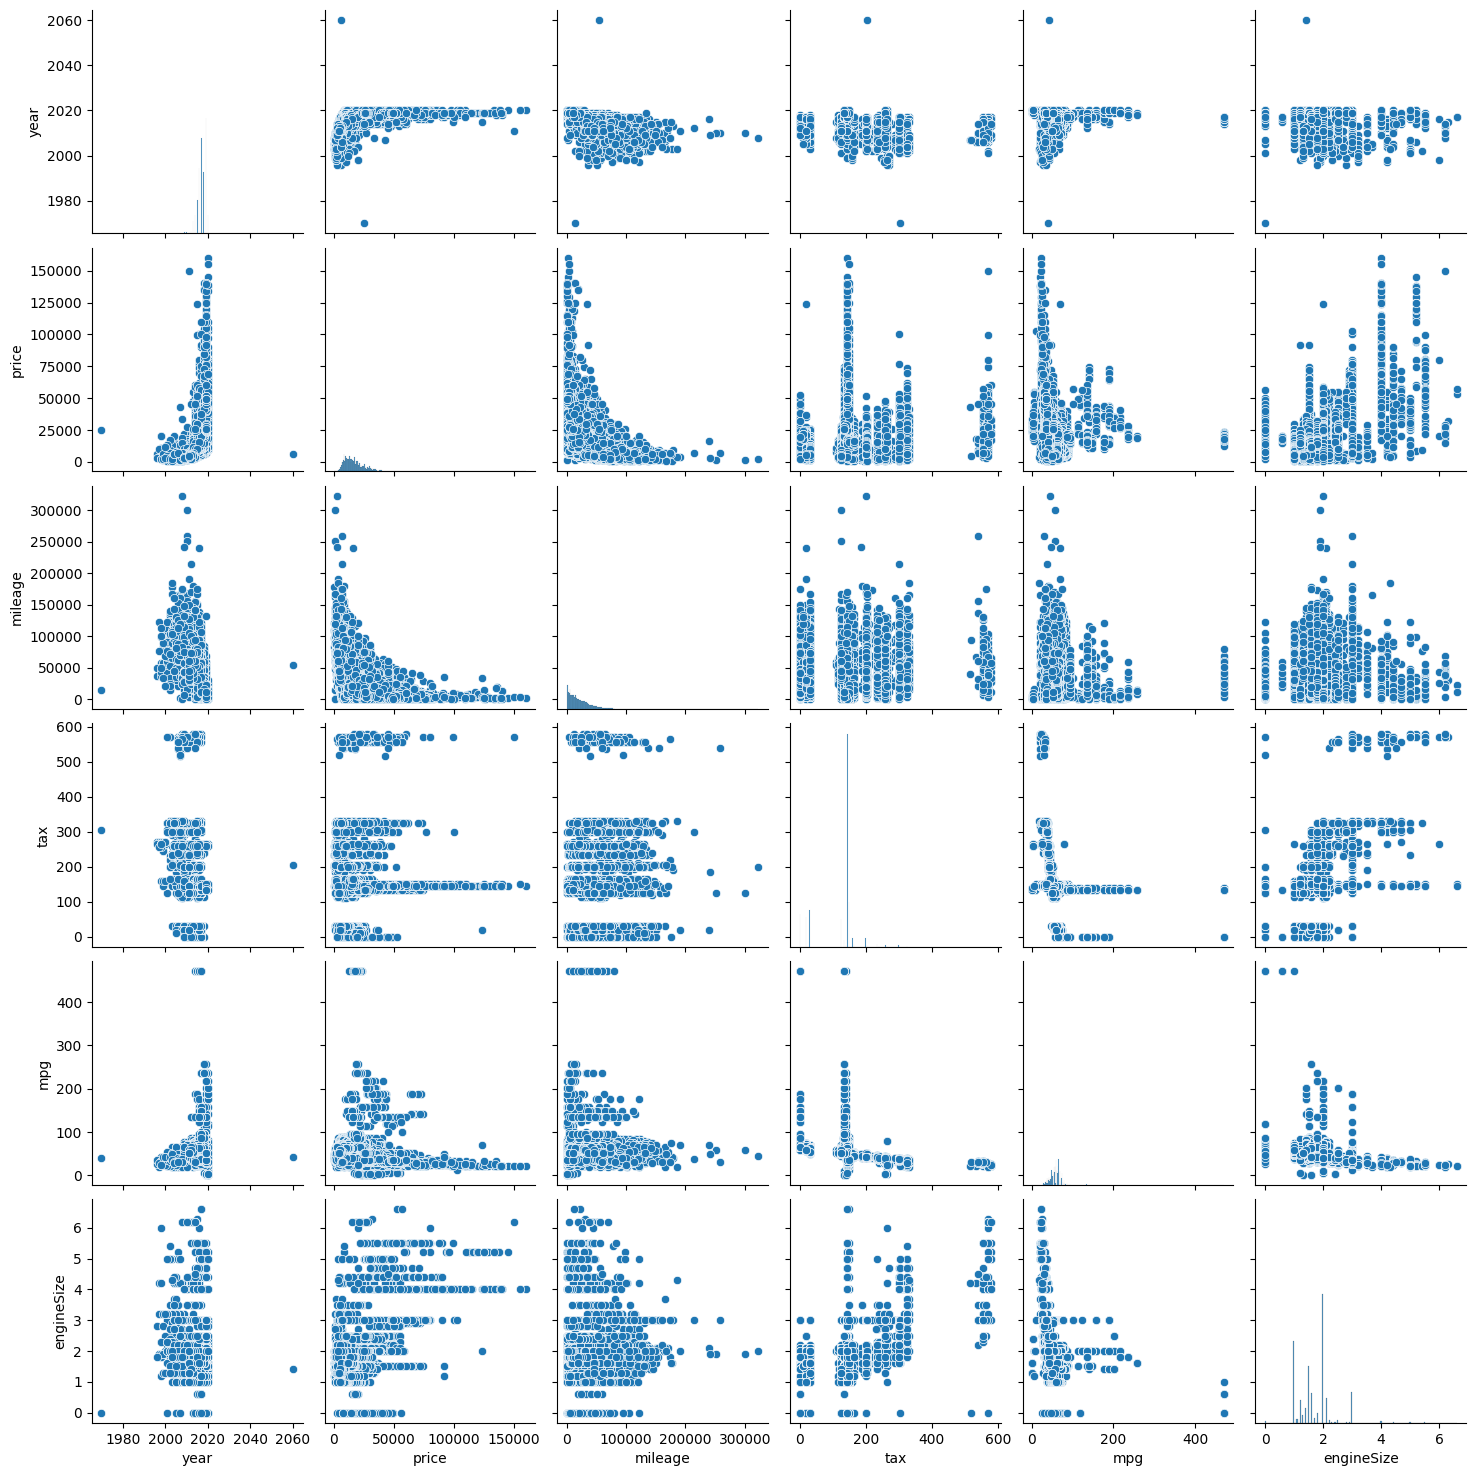

In [ ]:
sns.pairplot(df)

Dropping row with the year 2060 which seems a wrong entry and year 1970

In [ ]:
df=df[(df['year']!=2060) & (df['year']!=1970)]

In [ ]:
numerical_cols=[col for col in df.columns if df[col].dtype != 'object']
categorical_cols=[col for col in df.columns if df[col].dtype == 'object']


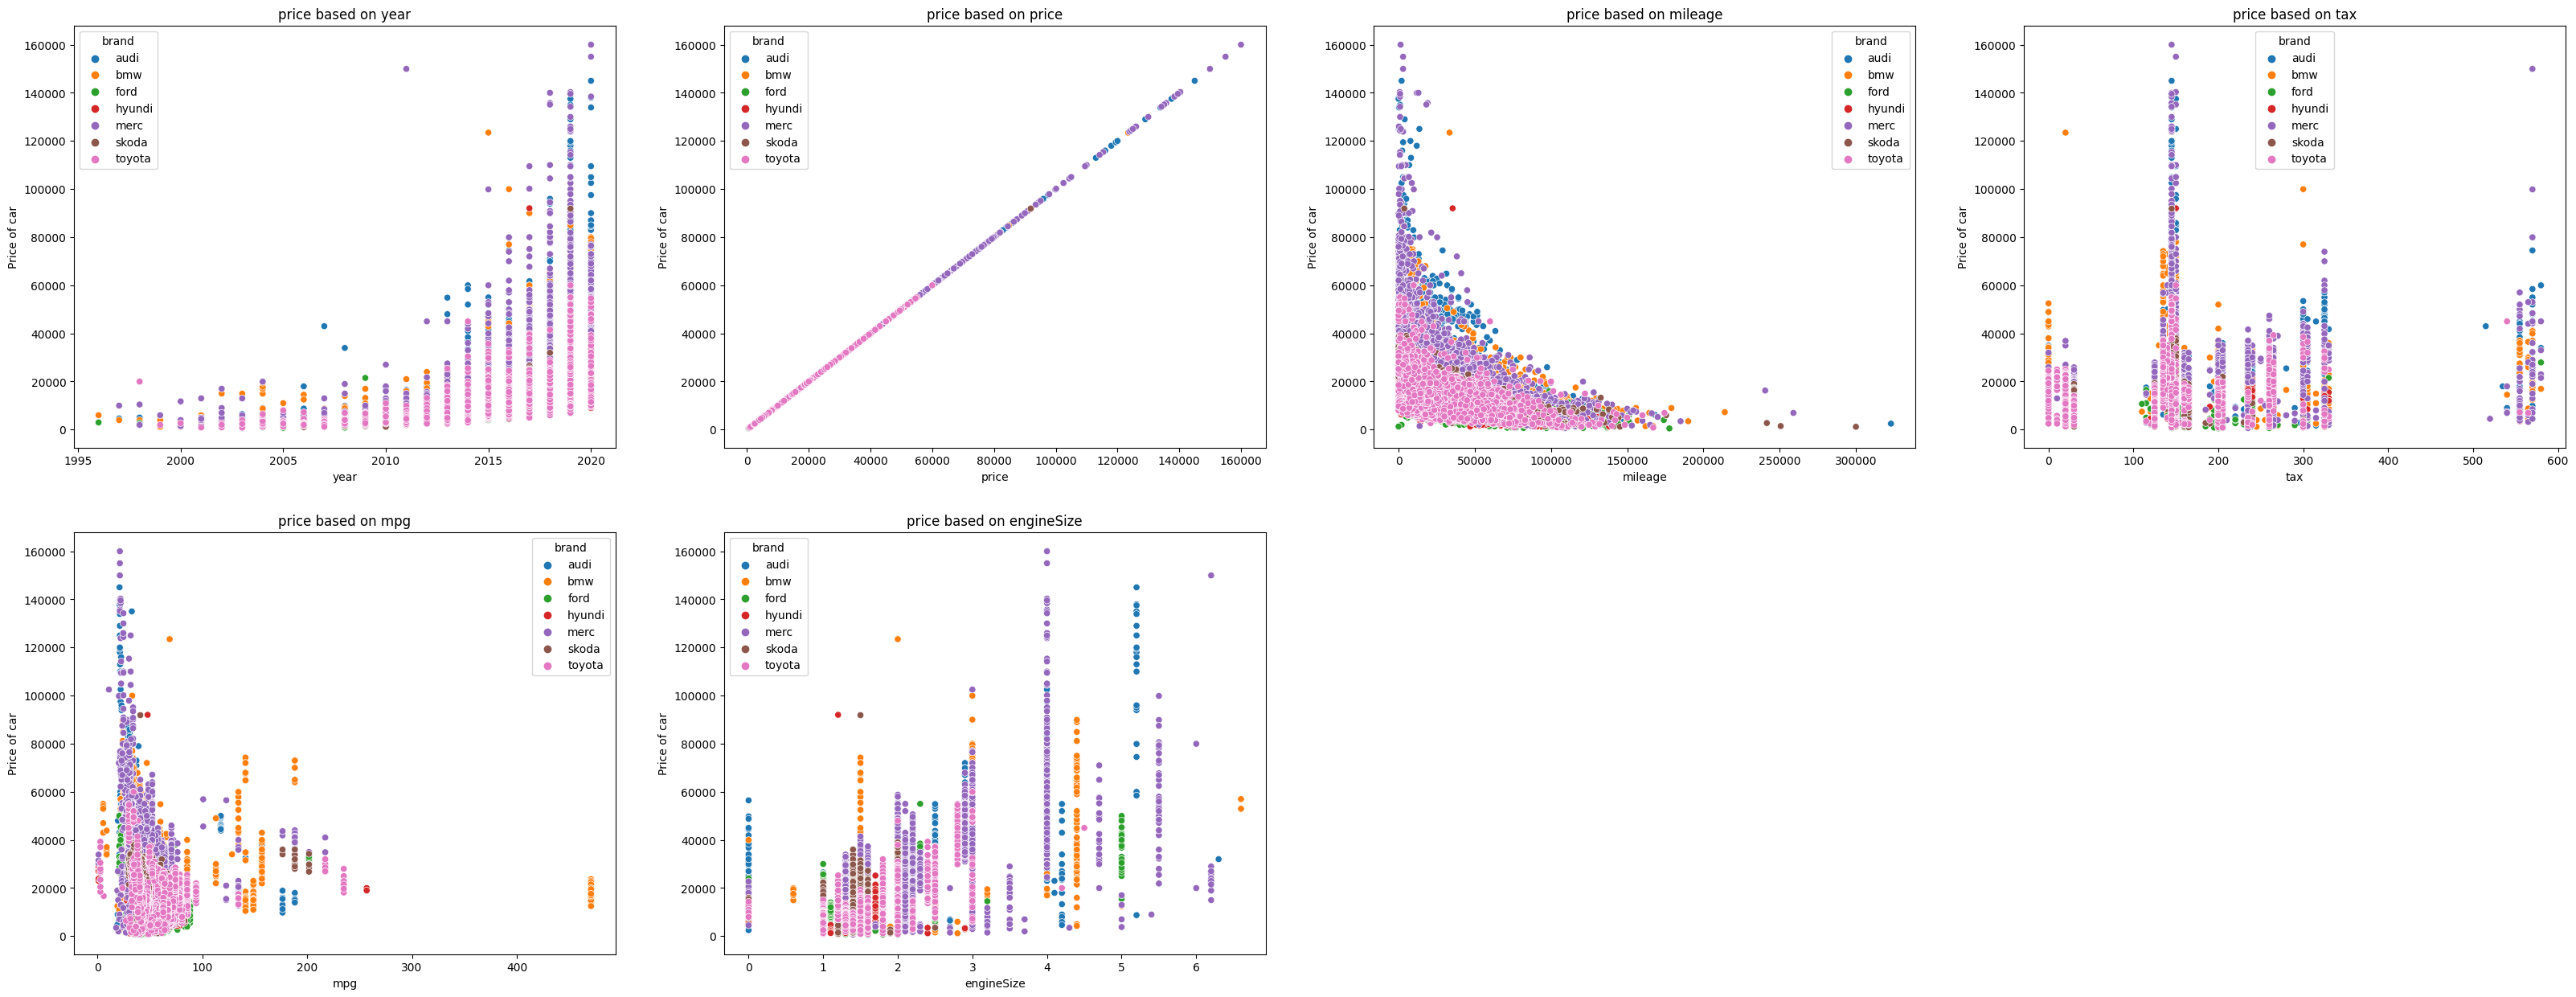

In [ ]:
fig=plt.figure(figsize=(40, 15))
for i in range(len(numerical_cols)):
  plt.subplot(2,4,i+1)
  plt.title(f'price based on {numerical_cols[i]}')
  plt.xlabel(numerical_cols[i])
  plt.ylabel('Price of car')
  sns.scatterplot(data=df[numerical_cols], x=numerical_cols[i], y='price', hue=df['brand'])
plt.show()

For the scatter plot of price per year, milage, road tax, mpg we notice that mercedes is predominantly more expensive than toyota

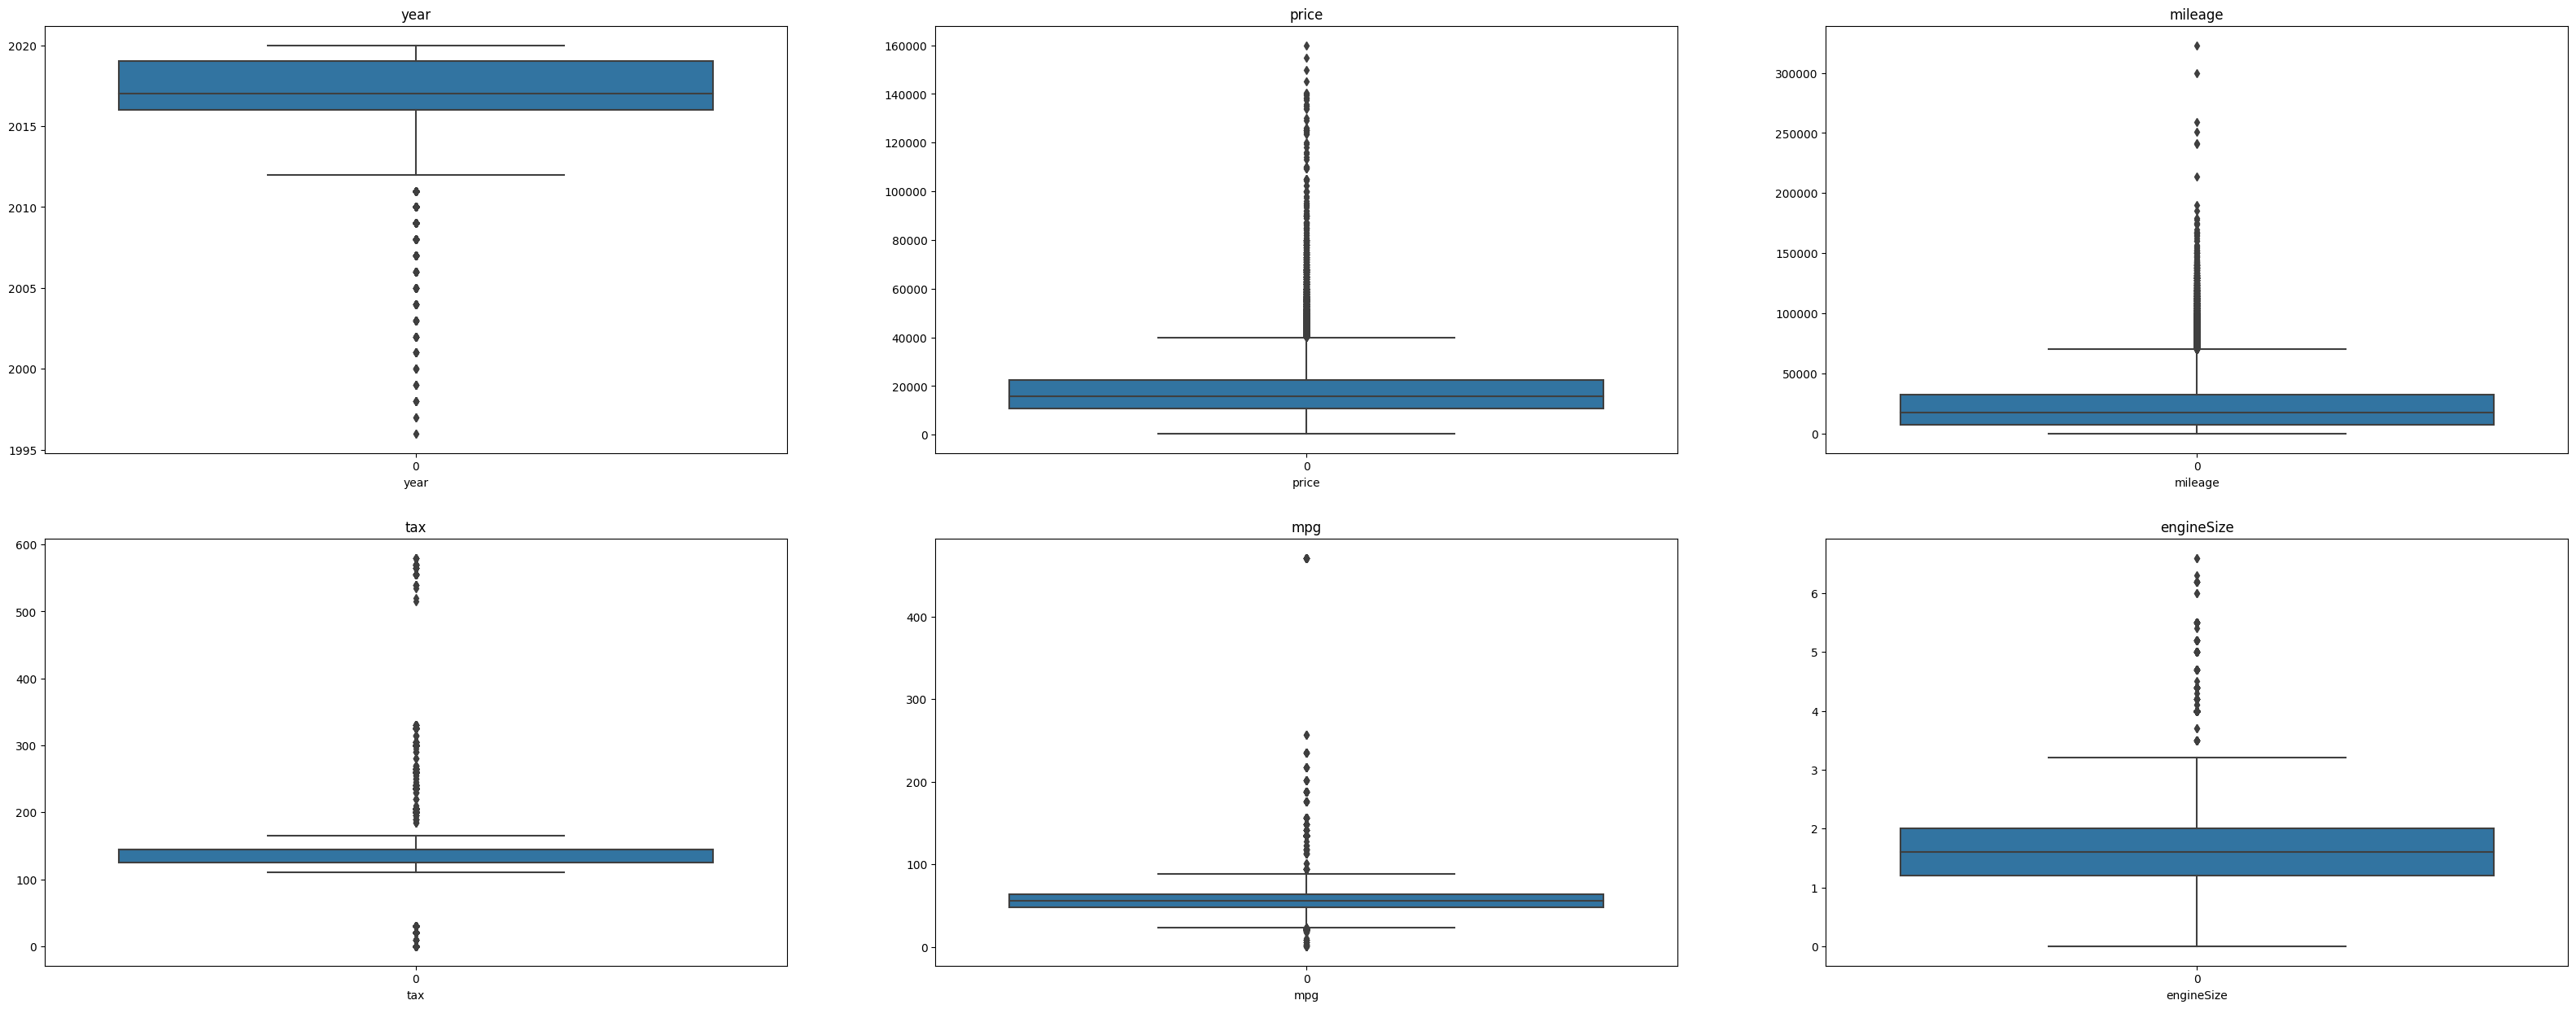

In [ ]:
fig=plt.figure(figsize=(40, 15))
for i in range(len(numerical_cols)):
  plt.subplot(2,3,i+1)
  plt.title(f'{numerical_cols[i]}')
  plt.xlabel(numerical_cols[i])
  sns.boxplot(df[numerical_cols[i]])
plt.show()

###log transformation for numerical variables

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


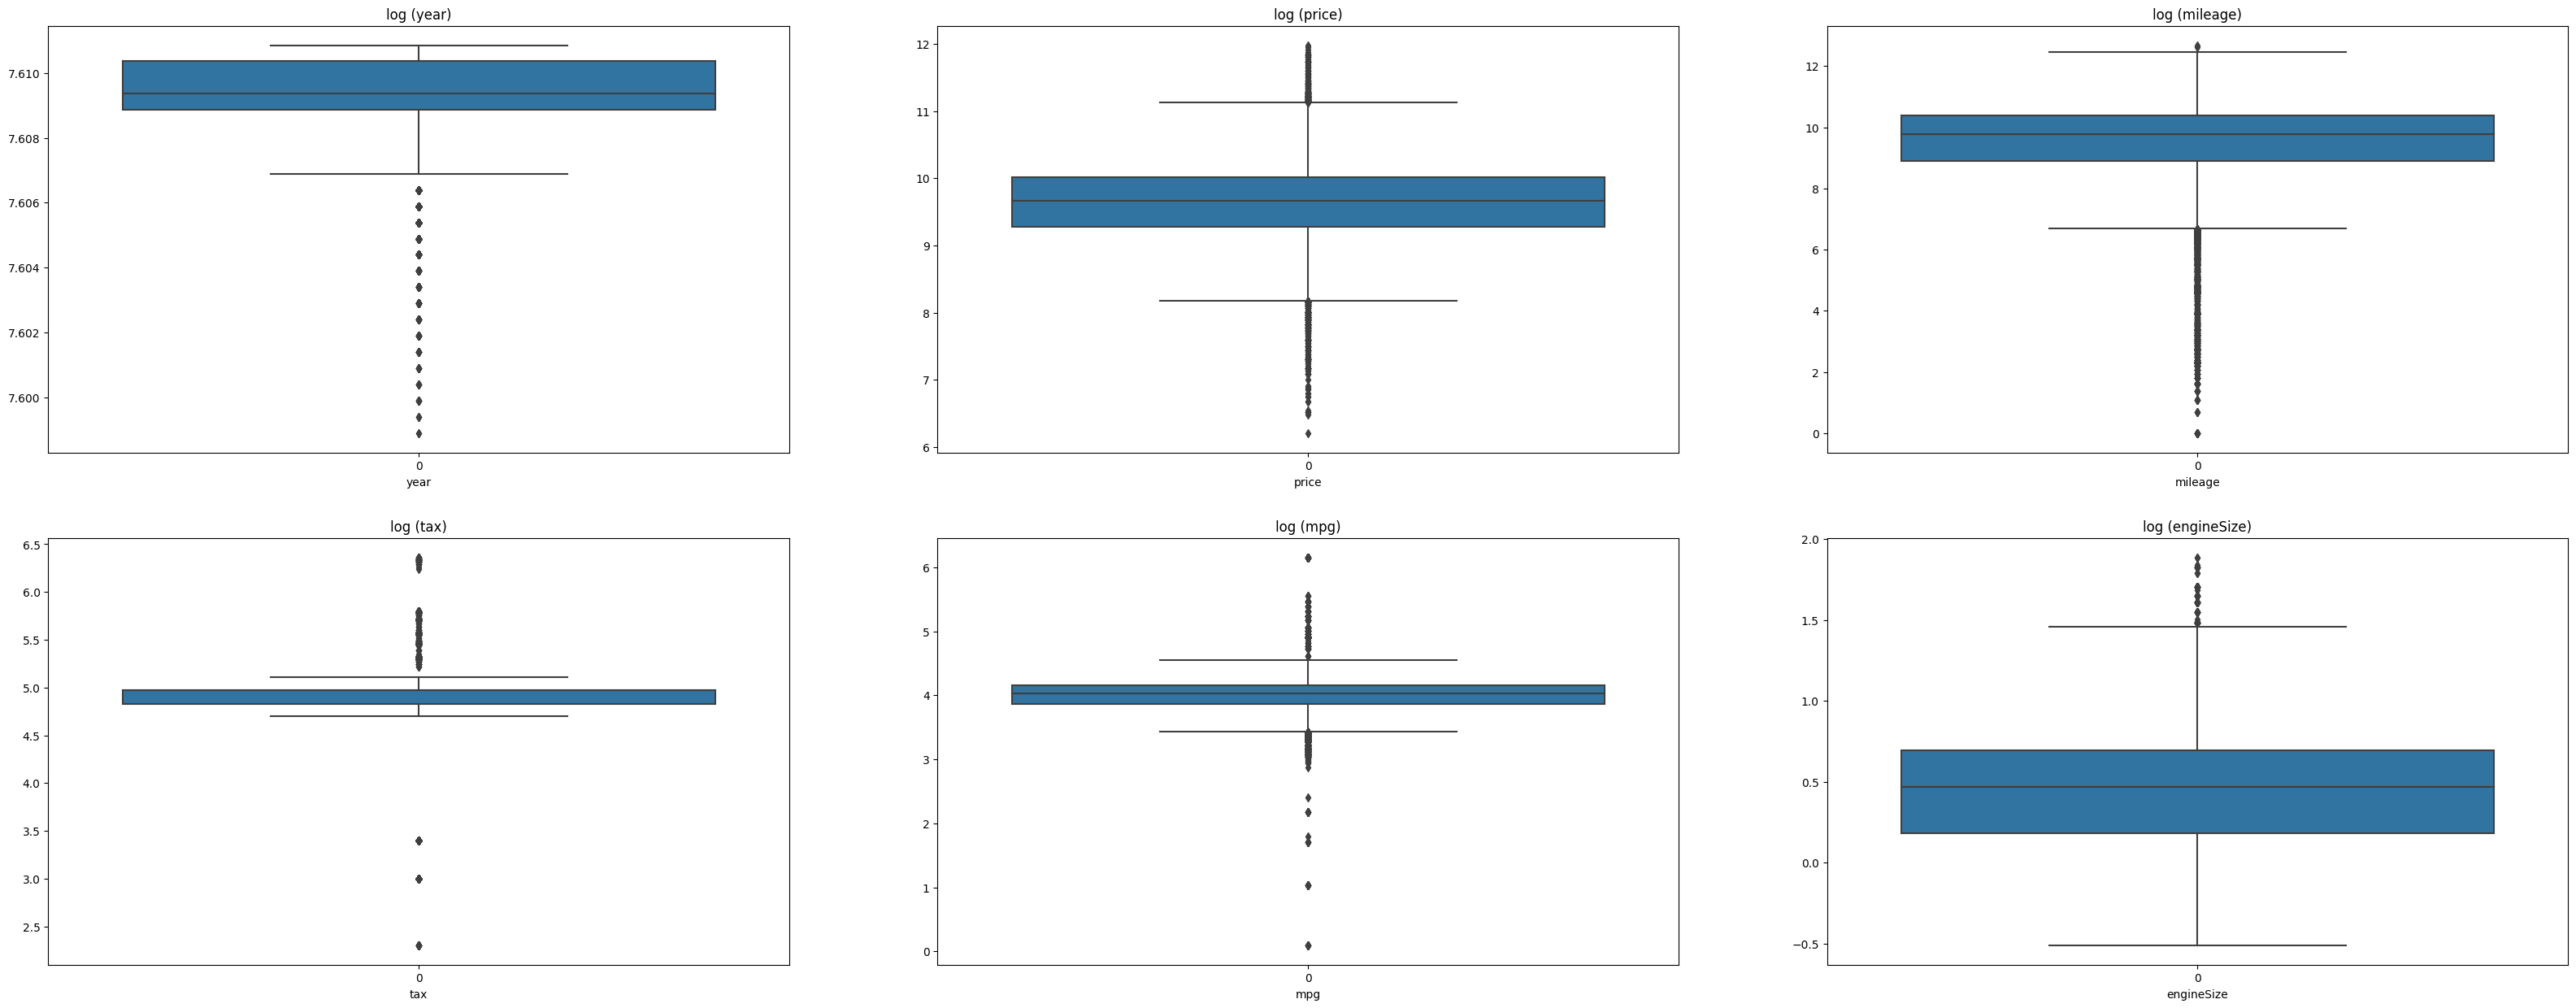

In [ ]:
fig=plt.figure(figsize=(40, 15))
for i in range(len(numerical_cols)):
  plt.subplot(2,3,i+1)
  plt.title(f'log ({numerical_cols[i]})')
  plt.xlabel(numerical_cols[i])
  sns.boxplot(np.log(df[numerical_cols[i]]))
plt.show()

###square root transformation for numerical variables

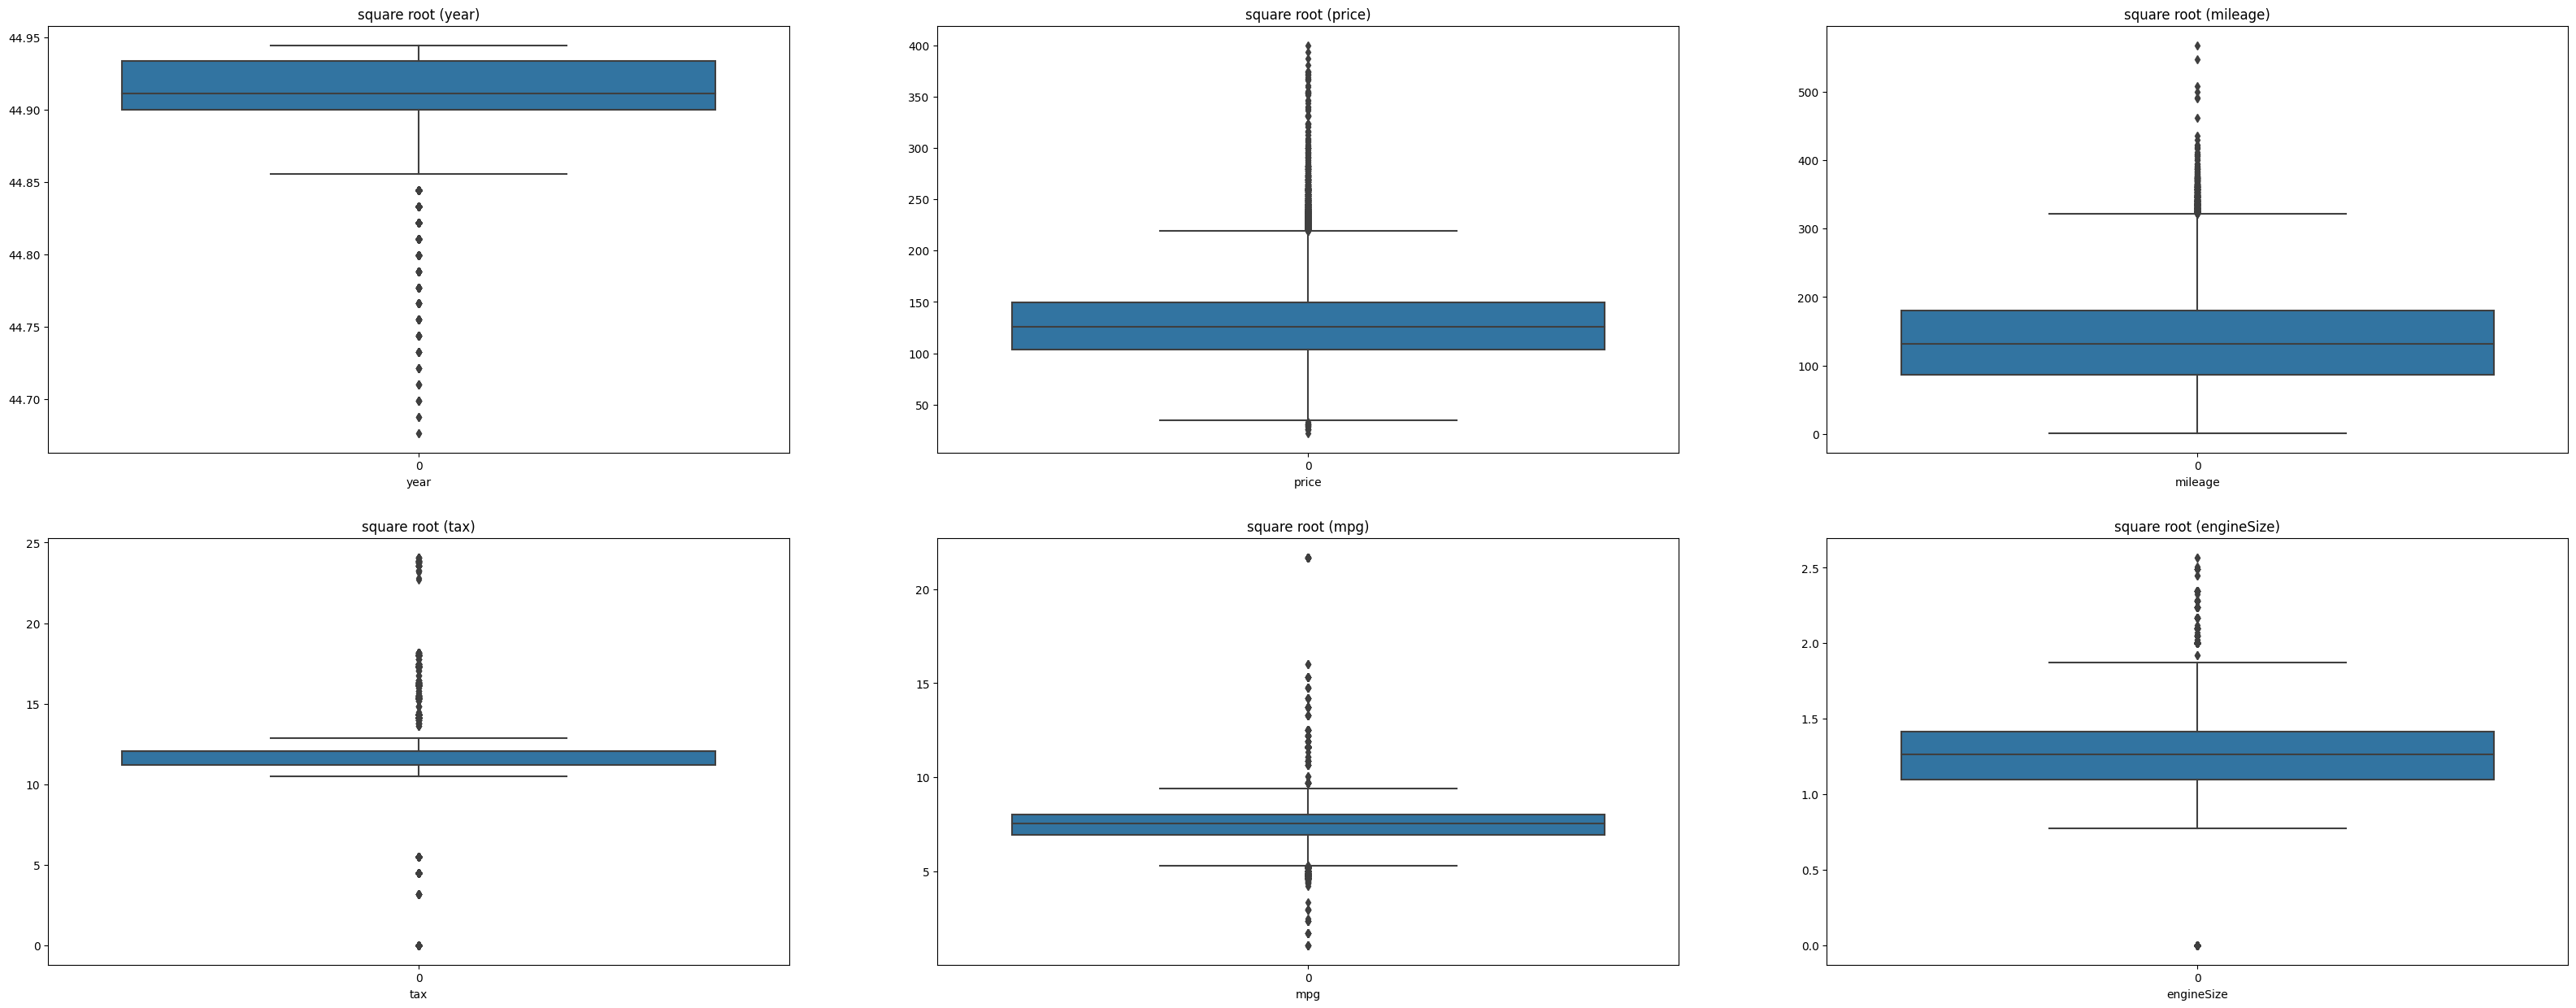

In [ ]:
fig=plt.figure(figsize=(40, 15))
for i in range(len(numerical_cols)):
  plt.subplot(2,3,i+1)
  plt.title(f'square root ({numerical_cols[i]})')
  plt.xlabel(numerical_cols[i])
  sns.boxplot(np.sqrt(df[numerical_cols[i]]))
plt.show()

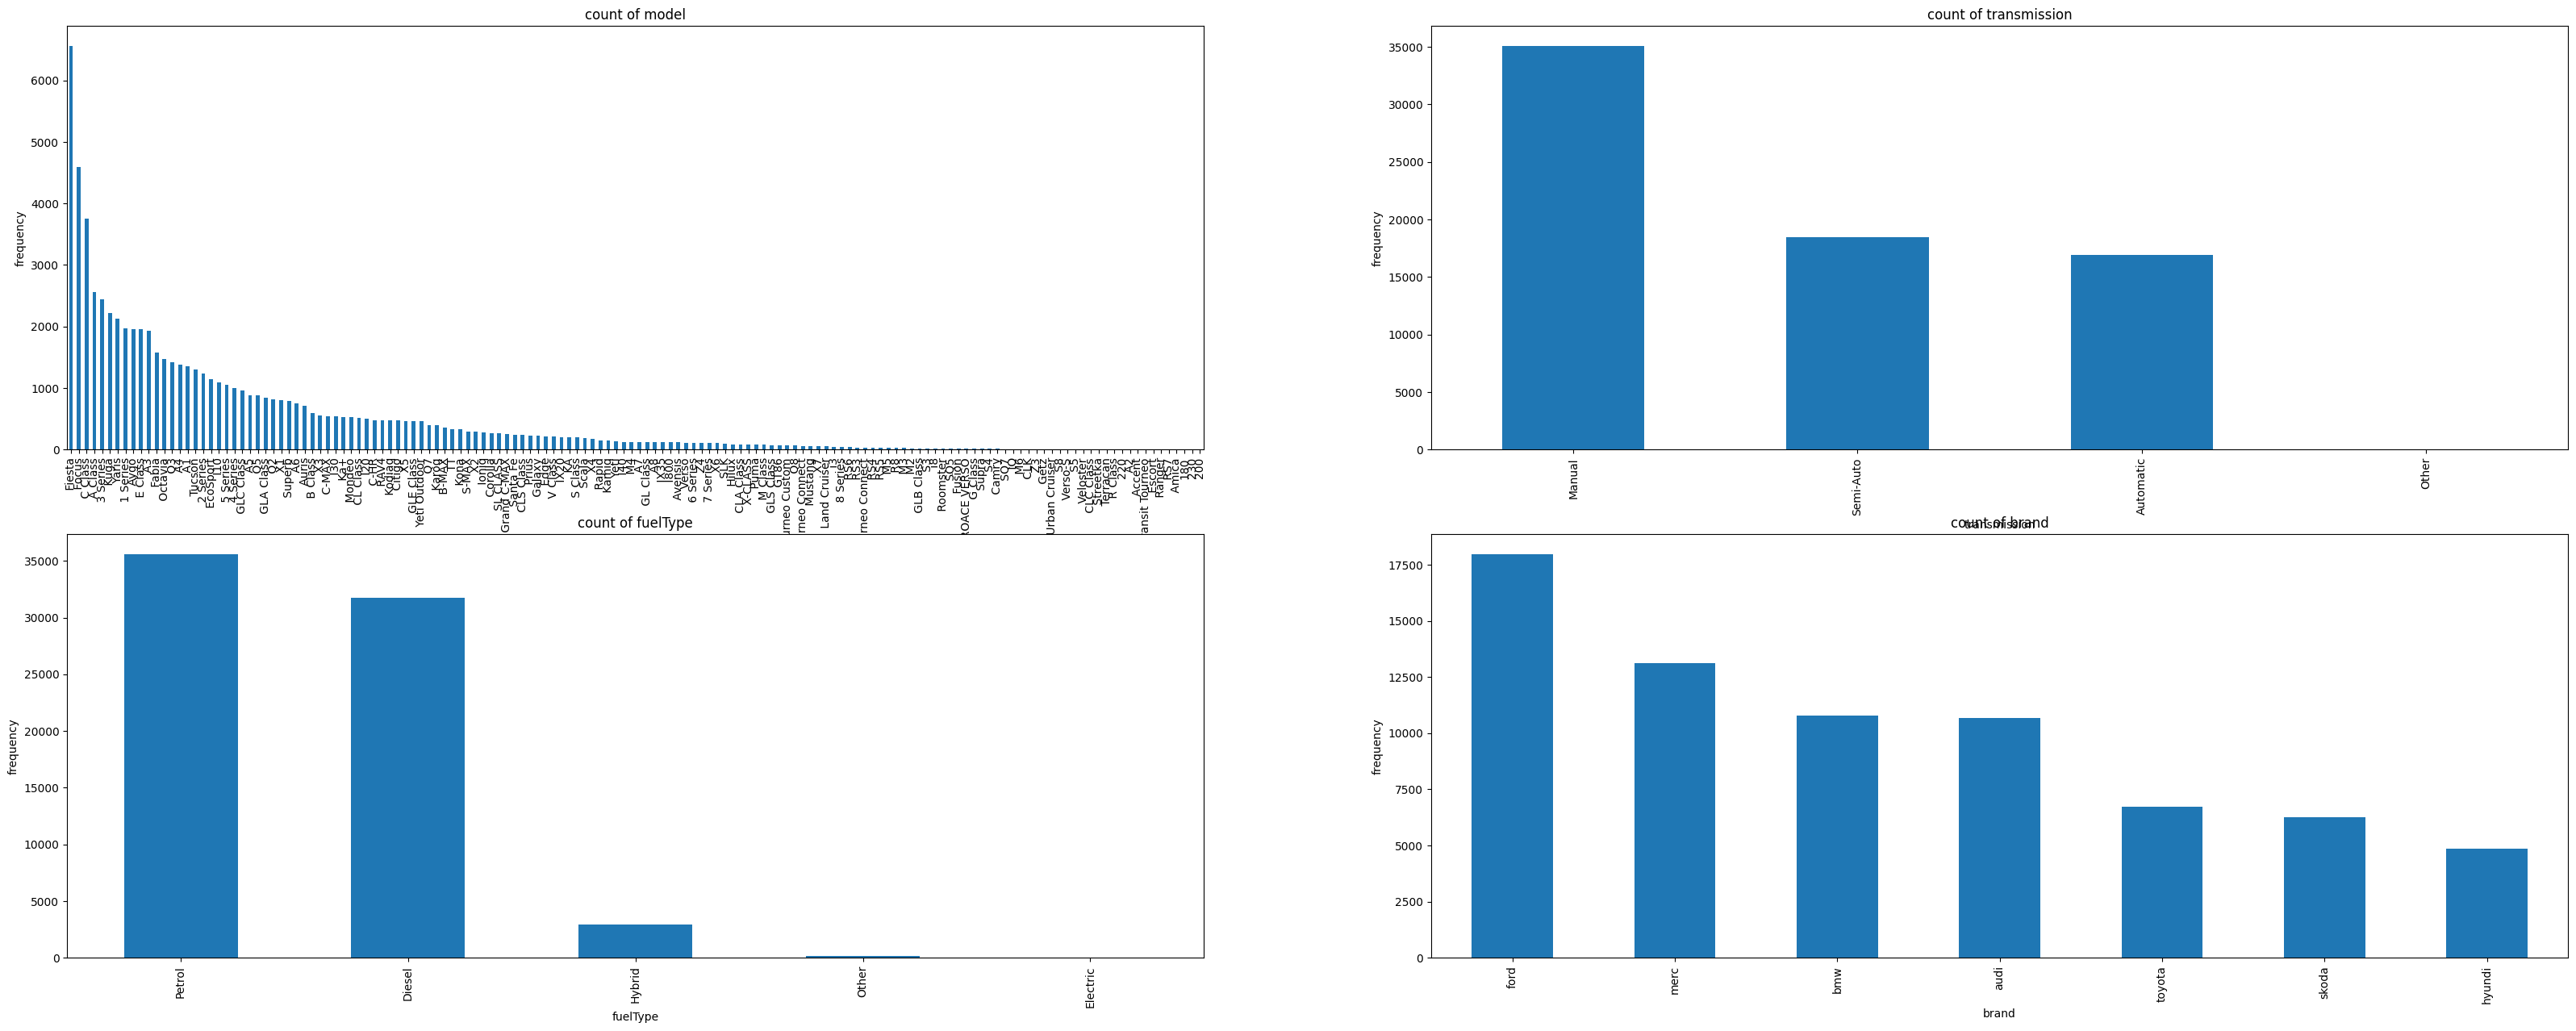

In [ ]:
cat_df=df[categorical_cols]
fig=plt.figure(figsize=(40, 15))
for i in range(len(cat_df.columns)):
  plt.subplot(2,2,i+1)
  plt.title(f'count of {cat_df.columns[i]}')
  plt.xlabel(cat_df.columns[i])
  plt.ylabel('frequency')
  cat_df[cat_df.columns[i]].value_counts().plot(kind='bar')
plt.show()

In [ ]:
df['transmission'].value_counts(normalize=True) * 100

Manual       49.786920
Semi-Auto    26.183306
Automatic    24.021251
Other         0.008523
Name: transmission, dtype: float64

In [ ]:
df['fuelType'].value_counts(normalize=True) * 100

Petrol      50.527019
Diesel      45.076425
Hybrid       4.163589
Other        0.225865
Electric     0.007103
Name: fuelType, dtype: float64

In [ ]:
df=df[(df['transmission']!='Other') & (df['fuelType']!='Electric') & (df['fuelType']!='Other')]

Drop rows with transmission equal to other (less than 0.01%) and fuel type equal to Electric and Other(both add up to less than 0.3%) because it's irrelevant to analysis

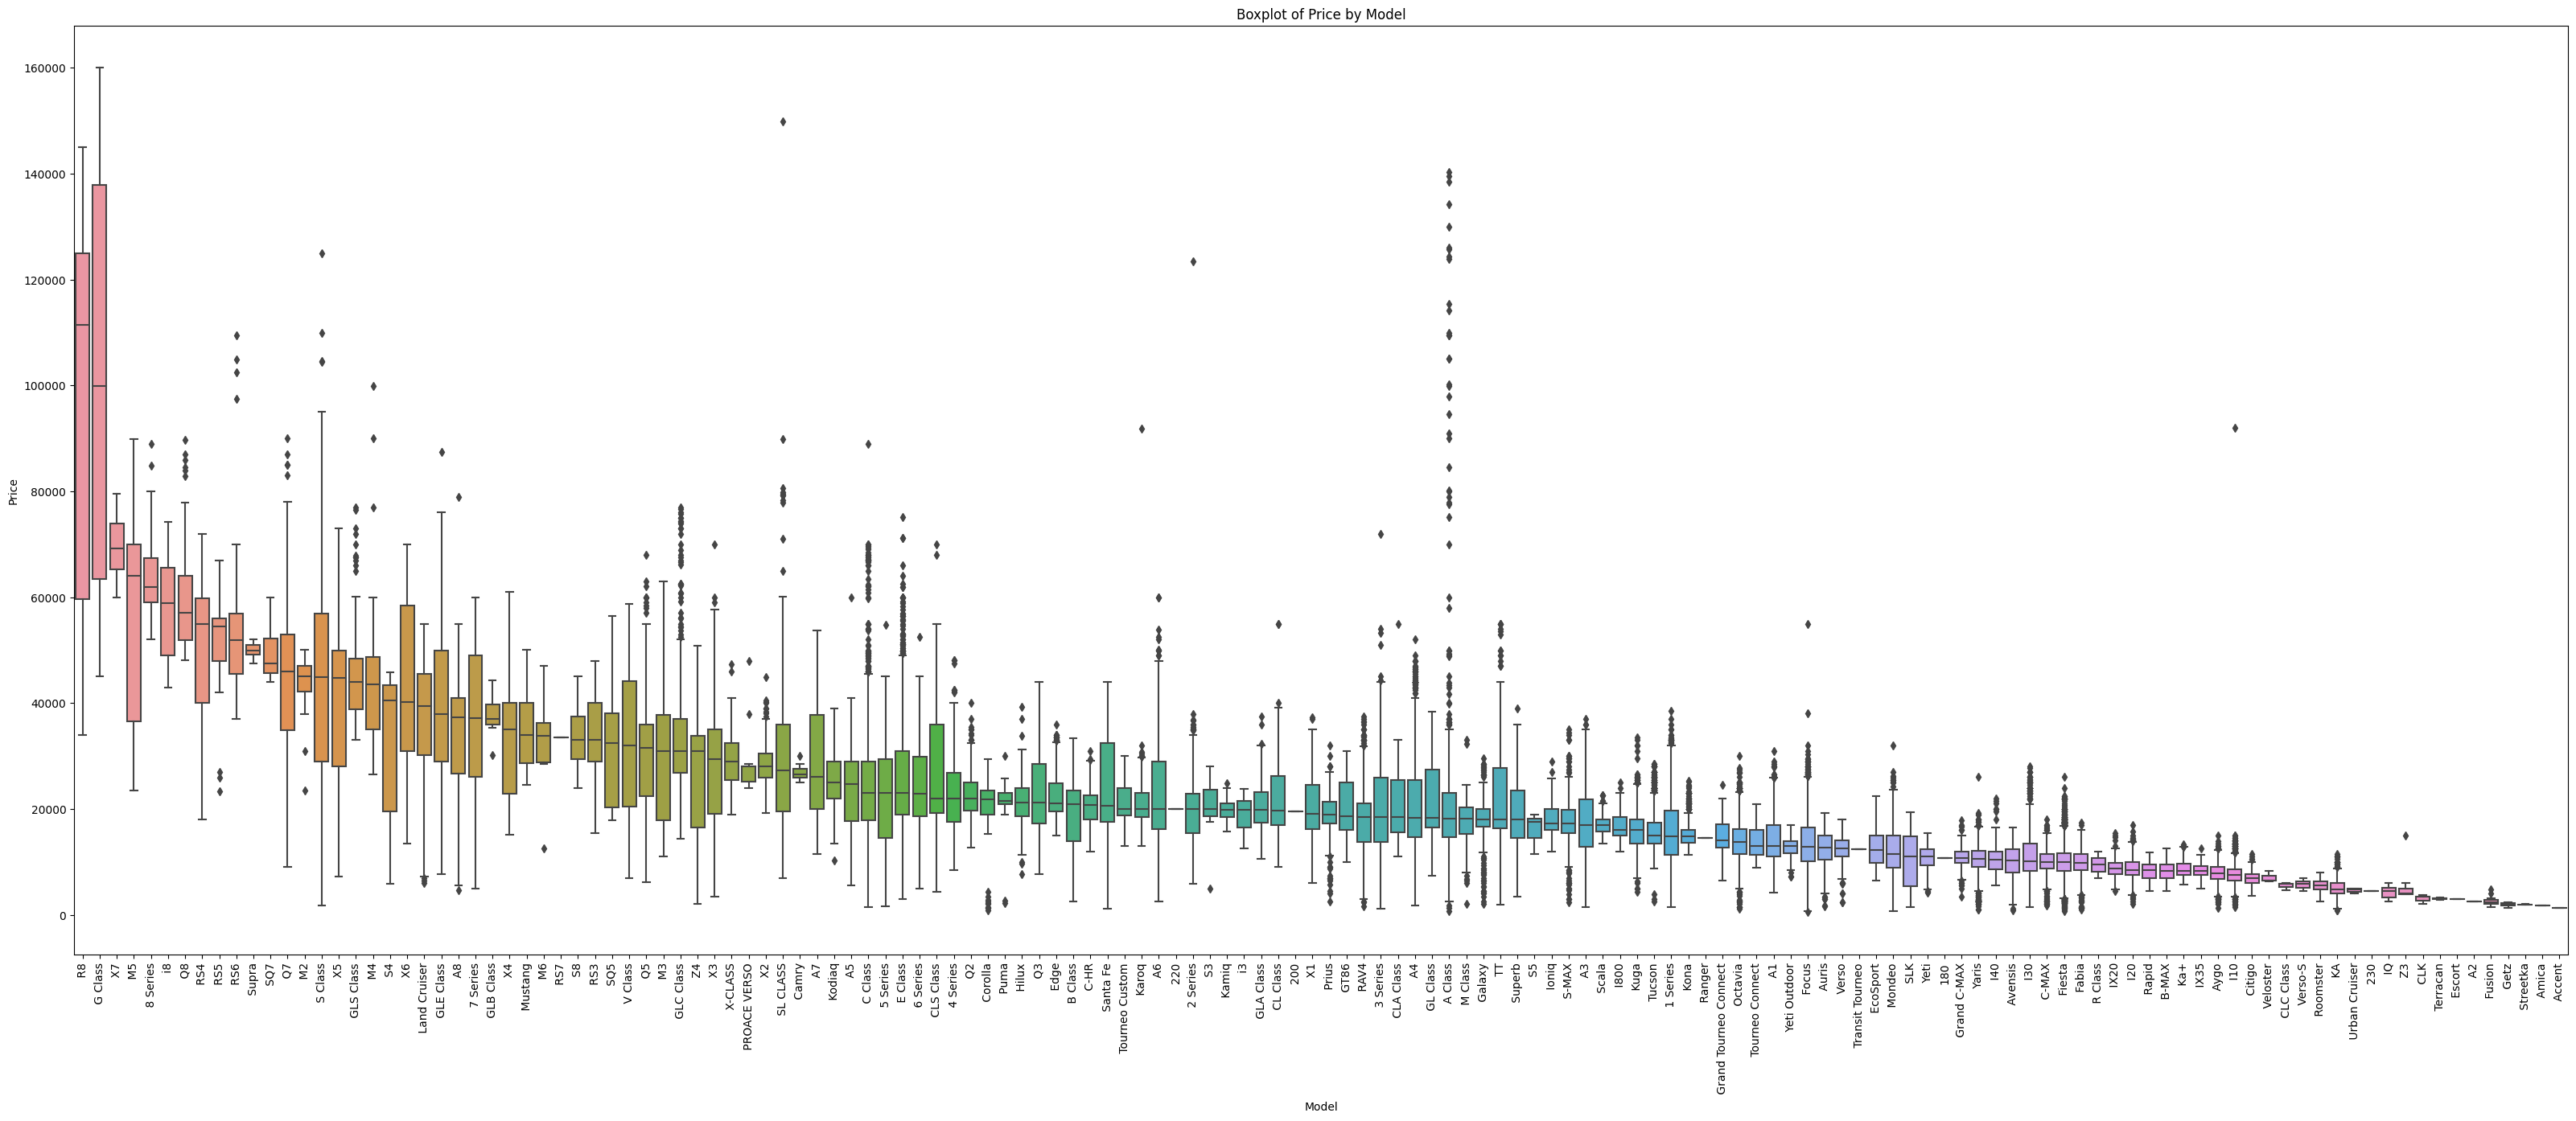

In [ ]:

# Create an ordered list of models based on median price
arranged_df = df.groupby('model', as_index=False).agg({'price': 'median'}).sort_values('price', ascending=False)
ordered_models = arranged_df['model'].tolist()

# Create the boxplot with the specified order
plt.figure(figsize=(40, 15))
plt.title('Boxplot of Price by Model')
sns.boxplot(data=df, x='model', y='price', order=ordered_models)
plt.xlabel('Model')
plt.xticks(rotation=90)  # Adjust rotation as needed
plt.ylabel('Price')
plt.show()


The audi R8 and mercedes G class have the biggest range in prices and relatively expensive

##Data Preprocessing

###Heatmaps

<ipython-input-27-8df7bcac526d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

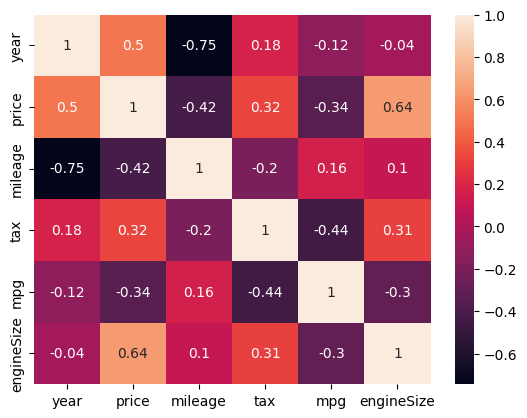

In [ ]:
sns.heatmap(df.corr(),annot=True)

<ipython-input-28-3a70f78ea53f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

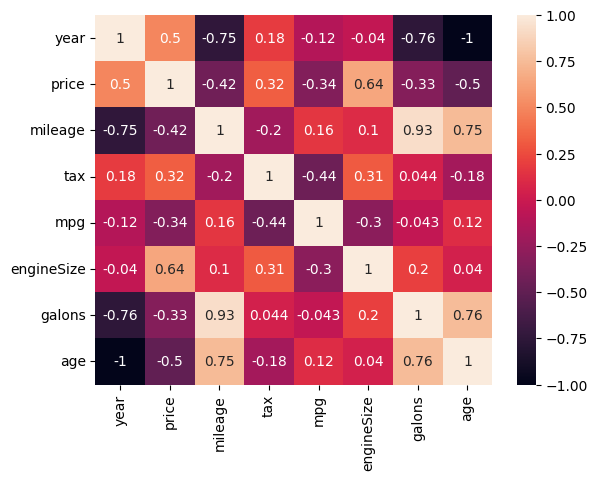

In [ ]:
df['galons']=df['mileage'] / df['mpg']
df['age']= 2020 - df['year']
sns.heatmap(df.corr(),annot=True)

###Mutual information

In [ ]:
df_copy=df.copy()
#Label encoding for categorical features
for colname in df_copy.select_dtypes('object'):
  df_copy[colname], _ = df_copy[colname].factorize()
discrete_features = df_copy.dtypes == int

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
'''mi_scores = make_mi_scores(df_copy, df_copy['price'], discrete_features)
mi_scores'''

"mi_scores = make_mi_scores(df_copy, df_copy['price'], discrete_features)\nmi_scores"

<Axes: >

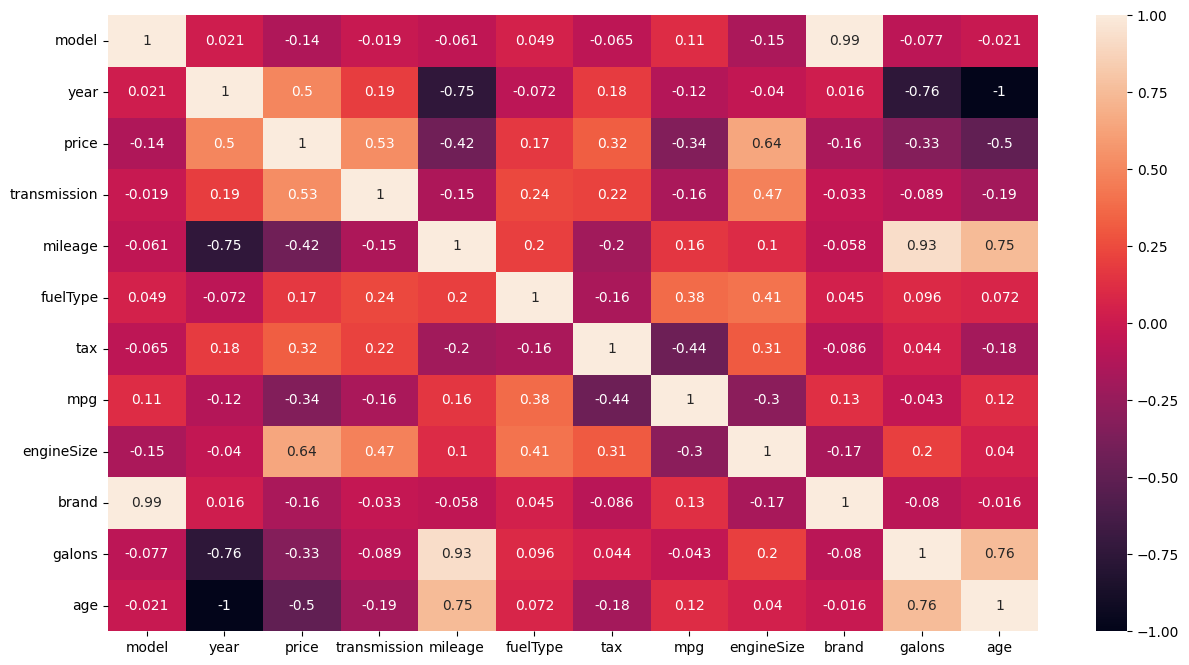

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_copy.corr(), annot=True)

###One hot encoding

In [ ]:
df=pd.get_dummies(df, columns=['fuelType', 'transmission', 'brand'])
df

,model,year,price,mileage,tax,mpg,engineSize,galons,age,fuelType_Diesel,...,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota
0,A1,2017,12500,15735,150.0,55.4,1.4,284.025271,3,0,...,0,1,0,1,0,0,0,0,0,0
1,A6,2016,16500,36203,20.0,64.2,2.0,563.909657,4,1,...,1,0,0,1,0,0,0,0,0,0
2,A1,2016,11000,29946,30.0,55.4,1.4,540.541516,4,0,...,0,1,0,1,0,0,0,0,0,0
3,A4,2017,16800,25952,145.0,67.3,2.0,385.616642,3,1,...,1,0,0,1,0,0,0,0,0,0
4,A3,2019,17300,1998,145.0,49.6,1.0,40.282258,1,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70393,IQ,2011,5500,30000,20.0,58.9,1.0,509.337861,9,0,...,1,0,0,0,0,0,0,0,0,1
70394,Urban Cruiser,2011,4985,36154,125.0,50.4,1.3,717.341270,9,0,...,0,1,0,0,0,0,0,0,0,1
70395,Urban Cruiser,2012,4995,46000,125.0,57.6,1.4,798.611111,8,1,...,0,1,0,0,0,0,0,0,0,1
70396,Urban Cruiser,2011,3995,60700,125.0,50.4,1.3,1204.365079,9,0,...,0,1,0,0,0,0,0,0,0,1


##Modelling

###splitting the data

In [ ]:
X=df.drop(columns=['price'])
y=df['price']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

ohe_model_train = pd.DataFrame(encoder.fit_transform(X_train[['model']]).toarray(), columns=encoder.get_feature_names_out(['model']))
ohe_model_test = pd.DataFrame(encoder.transform(X_test[['model']]).toarray(), columns=encoder.get_feature_names_out(['model']))

In [ ]:
X_train.drop(columns='model', inplace=True)
X_test.drop(columns='model', inplace=True)

###Rescaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.43207015, -0.78143494,  0.37983115, ..., -0.47842075,
         3.18613386, -0.32227456],
       [-0.03612668, -0.10843692,  0.37983115, ...,  2.09021036,
        -0.31386001, -0.32227456],
       [-0.97252035, -0.06389925,  0.07008906, ..., -0.47842075,
        -0.31386001, -0.32227456],
       ...,
       [ 0.90026699, -0.91941716,  0.37983115, ..., -0.47842075,
        -0.31386001, -0.32227456],
       [-0.97252035,  0.03992802, -1.86579896, ..., -0.47842075,
        -0.31386001, -0.32227456],
       [ 1.36846382, -1.06444647,  0.37983115, ...,  2.09021036,
        -0.31386001, -0.32227456]])

In [ ]:
X_train

,year,mileage,tax,mpg,engineSize,galons,age,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota
5772,2017,21585,145.0,40.9,2.0,527.750611,3,0,0,1,0,0,1,1,0,0,0,0,0,0
2635,2019,23,145.0,40.4,2.0,0.569307,1,0,0,1,0,0,1,1,0,0,0,0,0,0
26019,2018,22988,145.0,56.5,1.0,406.867257,2,0,0,1,0,1,0,0,0,1,0,0,0,0
40072,2014,47210,150.0,47.1,1.4,1002.335456,6,0,0,1,0,1,0,0,0,0,1,0,0,0
67328,2016,18842,0.0,69.0,1.0,273.072464,4,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37235,2016,25320,125.0,54.3,1.2,466.298343,4,0,0,1,0,1,0,0,0,1,0,0,0,0
6265,2019,2308,145.0,34.5,2.0,66.898551,1,0,0,1,0,0,1,1,0,0,0,0,0,0
54933,2016,33000,145.0,56.5,2.1,584.070796,4,1,0,0,1,0,0,0,0,0,0,1,0,0
860,2020,556,145.0,47.9,1.0,11.607516,0,0,0,1,0,1,0,1,0,0,0,0,0,0


###Polynomial Features transformation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_features=PolynomialFeatures(degree=3)
X_train_poly_3 = poly_features.fit_transform(X_train)
X_test_poly_3 = poly_features.transform(X_test)

In [ ]:
# Convert the one-hot encoded array to a NumPy array
ohe_model_train_array = ohe_model_train.to_numpy()

# Concatenate the NumPy arrays
X_train_poly_3 = np.concatenate((X_train_poly_3, ohe_model_train_array), axis=1)

In [ ]:
# Convert the one-hot encoded array to a NumPy array
ohe_model_test_array = ohe_model_test.to_numpy()

# Concatenate the NumPy arrays
X_test_poly_3 = np.concatenate((X_test_poly_3, ohe_model_test_array), axis=1)

Select Important features from XGBRegressor

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

xgb=XGBRegressor()
selector = SelectFromModel(xgb, threshold='mean')
selector.fit(X_train_poly_3, y_train)
X_train_poly_3 = selector.transform(X_train_poly_3)
X_test_poly_3 = selector.transform(X_test_poly_3)

In [ ]:
X_train_poly_3.shape

(56181, 202)

In [ ]:
X_1 = np.concatenate((X_train_poly_3, X_test_poly_3), axis=0)
y_1 = np.concatenate((y_train, y_test), axis=0)

In [ ]:
print(X_1.shape, y_1.shape)

(70227, 202) (70227,)


In [ ]:
def objective_xgb(trial):
    # Define the search space for XGBRegressor hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 1, 5)

    # Create and fit the XGBRegressor with the suggested hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        random_state=42
    )
    model.fit(X_train_poly_3, y_train)

    # Evaluate the model using RMSE
    y_pred = model.predict(X_test_poly_3)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2=r2_score(y_test, y_pred)
    return rmse, r2


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
import optuna
xgb_study = optuna.create_study(direction="minimize")

# Optimize the XGBRegressor
xgb_study.optimize(objective_xgb, n_trials=20)


[I 2023-09-27 15:08:59,454] A new study created in memory with name: no-name-86eacd84-7cba-4122-8af6-bff770f78974
[W 2023-09-27 15:14:44,098] Trial 0 failed with parameters: {'n_estimators': 306, 'learning_rate': 0.15724770756350717, 'max_depth': 9, 'min_child_weight': 1.3613173834034606} because of the following error: The number of the values 2 did not match the number of the objectives 1.
[W 2023-09-27 15:14:44,103] Trial 0 failed with value (2108.3223900469734, 0.9626929106013697).
[W 2023-09-27 15:23:05,627] Trial 1 failed with parameters: {'n_estimators': 491, 'learning_rate': 0.1855105140687167, 'max_depth': 9, 'min_child_weight': 2.6683619457268803} because of the following error: The number of the values 2 did not match the number of the objectives 1.
[W 2023-09-27 15:23:05,631] Trial 1 failed with value (2153.3976088488284, 0.9610806320291785).
[W 2023-09-27 15:25:37,533] Trial 2 failed with parameters: {'n_estimators': 274, 'learning_rate': 0.19673635267451856, 'max_depth': 

Modify Hyperparameters

Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
best_params = {'n_estimators': 354, 'learning_rate': 0.16883148645886878, 'max_depth': 8, 'min_child_weight': 1.9473488774371135}
xgb_tuned=XGBRegressor(**best_params)

In [ ]:
xgb_tuned_cv_results=cross_val_score(xgb_tuned, X_1, y_1, n_jobs=2, scoring='r2', cv=10)

In [ ]:
print(xgb_tuned_cv_results.mean())

0.9633633652971451


Train_test

In [ ]:
xgb_tuned.fit(X_train_poly_3, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16883148645886878,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1.9473488774371135, missing=nan,
             monotone_constraints=None, n_estimators=354, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
y_train_pred=xgb_tuned.predict(X_train_poly_3)
y_test_pred=xgb_tuned.predict(X_test_poly_3)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
acc_train=r2_score(y_train_pred, y_train)
acc_train

0.988327726439739

In [ ]:
acc_test=r2_score(y_test_pred, y_test)
acc_test

0.9614842410239721